<img src="jupyter-spark.png" class="text-center" width="400px">
<h1 class="text-center huge">Jupyter Notebook + Spark</h1>

In [1]:
import os, sys
from glob import glob

# findspark makes pyspark importable:
from findspark import find_spark
spark_home = find_spark()
print("Using SPARK_HOME=%s" % spark_home)

from pyspark import SparkContext
sc = SparkContext(appName='notebook')

Using SPARK_HOME=/usr/local/opt/apache-spark/libexec


# Common words in Jane Austen

In [2]:
import nltk
nltk.download('stopwords')
nltk.download('gutenberg')
import nltk.corpus as corpus
stopwords = set(corpus.stopwords.words())

[nltk_data] Downloading package stopwords to /Users/minrk/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package gutenberg to /Users/minrk/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


Make a Spark RDD of Jane Austen's works on Project Gutenberg

In [3]:
austen = [
    corpus.gutenberg.abspath(name)
    for name in corpus.gutenberg.fileids()
    if name.startswith('austen-')
]
rdd = sc.textFile(','.join(austen))
rdd

/Users/minrk/nltk_data/corpora/gutenberg/austen-emma.txt,/Users/minrk/nltk_data/corpora/gutenberg/austen-persuasion.txt,/Users/minrk/nltk_data/corpora/gutenberg/austen-sense.txt MapPartitionsRDD[1] at textFile at NativeMethodAccessorImpl.java:-2

In [4]:
%%time
common = rdd \
    .flatMap(lambda line: line.split()) \
    .map(lambda word: word.strip().lower()) \
    .filter(lambda word: word not in stopwords) \
    .map(lambda word: (word, 1)) \
    .reduceByKey(lambda a, b: a + b) \
    .map(lambda (key, cnt): (cnt, key)) \


CPU times: user 135 ms, sys: 12.4 ms, total: 148 ms
Wall time: 421 ms


In [5]:
%time top = common.top(10)
top

CPU times: user 11.2 ms, sys: 3.5 ms, total: 14.7 ms
Wall time: 3.87 s


[(1789, u'could'),
 (1642, u'would'),
 (1265, u'mr.'),
 (1196, u'mrs.'),
 (1043, u'must'),
 (900, u'every'),
 (892, u'miss'),
 (875, u'much'),
 (871, u'said'),
 (851, u'one')]

*counting words from [tdhopper's presentation](http://nbviewer.ipython.org/format/slides/github/tdhopper/rta-pyspark-presentation/blob/master/slides.ipynb#/5)*

# Distribution of vowels in dictionary

In [6]:
words = sc.textFile("/usr/share/dict/words")

In [7]:
def count_vowels(word):
    c = 0
    for v in 'aeiou':
        c += word.count(v)
    return c
    

In [8]:
vowel_counts = [
    words.filter(lambda w: count_vowels(w) == i).count()
    for i in range(10)
]

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

enabling inline matplotlib


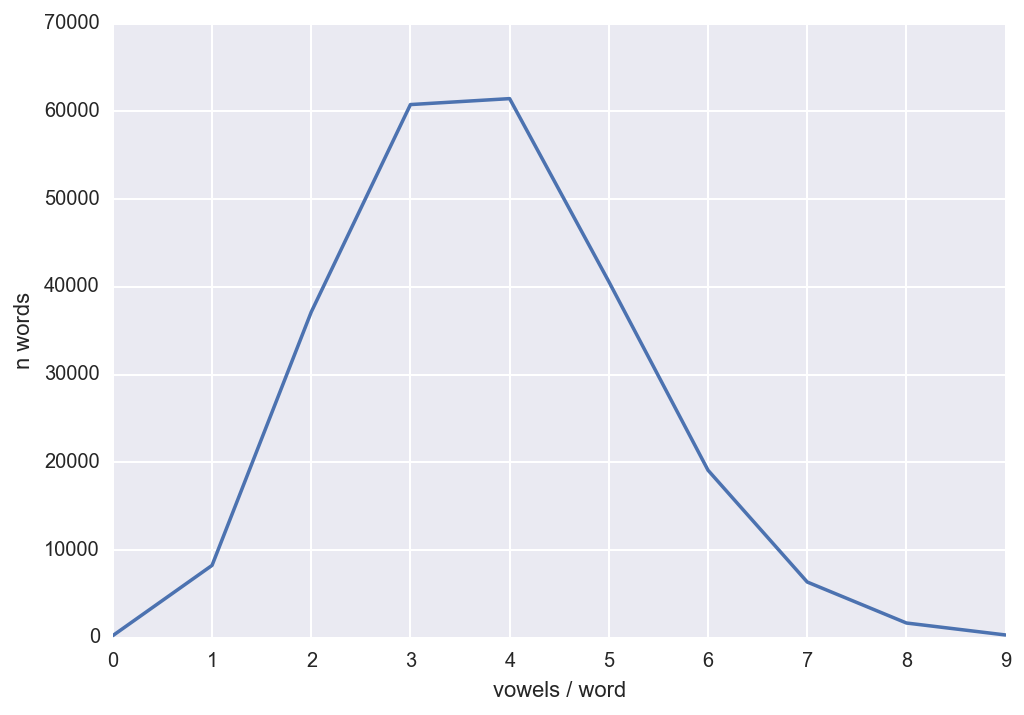

In [10]:
plt.plot(vowel_counts)
plt.ylabel("n words")
plt.xlabel("vowels / word")

See [codeneuro](http://datasets.codeneuro.org/) for a demo of Spark in Python + Jupyter with tmpnb